In [4]:
import os

dataset_path = r'C:\Users\ahmed\OneDrive\Desktop\Skin\skin-disease-datasaet'

print("Files in dataset path:")
print(os.listdir(dataset_path))

Files in dataset path:
['test_set', 'train_set']


In [5]:
# Define paths for the train and test sets
train_path = os.path.join(dataset_path, "train_set")
test_path = os.path.join(dataset_path, "test_set")

# List contents of the train and test sets
print("Files in train set:")
print(os.listdir(train_path))


Files in train set:
['BA- cellulitis', 'BA-impetigo', 'FU-athlete-foot', 'FU-nail-fungus', 'FU-ringworm', 'PA-cutaneous-larva-migrans', 'VI-chickenpox', 'VI-shingles']


In [7]:
pip install scikit-learn


   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.0 MB 419.4 kB/s eta 0:00:26
   - -------------------------------------- 0.5/11.0 MB 419.4 kB/s eta 0:00:26
   - -------------------------------------- 0.5/11.0 MB 419.4 kB/s eta 0:00:26
   -- ------------------------------------- 0.8/11.0 MB 424.5 

In [9]:
pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/7.8 MB 275.1 kB/s eta 0:00:27
   -- ------------------------------------- 0.5/7.8 MB 275.1 kB/s eta 0:00:27
   -- ------------------------------------- 0.5/7.8 MB 275.1 kB/s eta 0:00:27
   -- ------------------------------------- 0.5/7.8 MB 275.1 kB/s eta 0:00:27
   

In [10]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

In [11]:
def preprocess_image(img):
    if img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (299, 299))  # Resize to 299x299
    img = img.astype('float32')
    img = preprocess_input(img)
    return img

In [12]:
# Load and preprocess data
def load_data(data_path):
    data = []
    for folder in os.listdir(data_path):
        folder_path = os.path.join(data_path, folder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            img = cv2.imread(file_path)
            img = preprocess_image(img)  # Apply preprocessing to each image
            data.append((img, folder))
    return data

train_data = load_data(train_path)
test_data = load_data(test_path)

In [13]:
# Prepare training and validation sets
X_train, y_train = zip(*train_data)
X_val, y_val = zip(*test_data)

X_train = np.array(X_train)
X_val = np.array(X_val)

# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

y_train_one_hot = to_categorical(y_train_encoded, num_classes=8)
y_val_one_hot = to_categorical(y_val_encoded, num_classes=8)

In [14]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [17]:
from tensorflow.keras.layers import BatchNormalization
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in base_model.layers[:-10]:  # Fine-tune more layers
    layer.trainable = False
class CustomBatchNormalization(BatchNormalization):
    def get_config(self):
        config = super().get_config()
        config['axis'] = -1  # Explicitly set axis as an integer
        return config

# Replace BatchNormalization in the model with CustomBatchNormalization
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    CustomBatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')
])


In [18]:
# Metrics for evaluation
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    return 2 * (precision_value * recall_value) / (precision_value + recall_value + K.epsilon())

import tensorflow as tf

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weights_dict = dict(enumerate(class_weights))

# Compile model
class_weights_dict = dict(enumerate(class_weights))

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [22]:
y_train_one_hot = y_train_one_hot.astype('float32')
y_val_one_hot = y_val_one_hot.astype('float32')

In [28]:
for i in range(5):
    sample_batch, sample_labels = next(datagen.flow(X_train, y_train_one_hot, batch_size=32))
    print(f"Batch {i+1} - Sample batch shape: {sample_batch.shape}, Sample labels shape: {sample_labels.shape}")

Batch 1 - Sample batch shape: (32, 299, 299, 3), Sample labels shape: (32, 8)
Batch 2 - Sample batch shape: (32, 299, 299, 3), Sample labels shape: (32, 8)
Batch 3 - Sample batch shape: (32, 299, 299, 3), Sample labels shape: (32, 8)
Batch 4 - Sample batch shape: (32, 299, 299, 3), Sample labels shape: (32, 8)
Batch 5 - Sample batch shape: (32, 299, 299, 3), Sample labels shape: (32, 8)


In [29]:
history = model.fit(
    datagen.flow(X_train, y_train_one_hot, batch_size=32),
    epochs=50,
    validation_data=(X_val, y_val_one_hot),
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 183s 6s/step - accuracy: 0.3017 - loss: 2.2945 - val_accuracy: 0.7137 - val_loss: 0.9536 - learning_rate: 1.0000e-04
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 163s 6s/step - accuracy: 0.7295 - loss: 0.7971 - val_accuracy: 0.8248 - val_loss: 0.5845 - learning_rate: 1.0000e-04
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 160s 6s/step - accuracy: 0.8729 - loss: 0.4236 - val_accuracy: 0.9103 - val_loss: 0.3553 - learning_rate: 1.0000e-04
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 159s 6s/step - accuracy: 0.8973 - loss: 0.3174 - val_accuracy: 0.9316 - val_loss: 0.2668 - learning_rate: 1.0000e-04
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - accuracy: 0.9324 - loss: 0.2368 - val_accuracy: 0.9359 - val_loss: 0.2114 - learning_rate: 1.0000e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.9279 - loss: 0.2054 - val_accuracy: 0.9402 - val_loss: 0.1768 - learning_rate: 1.0000e-04
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.9241 

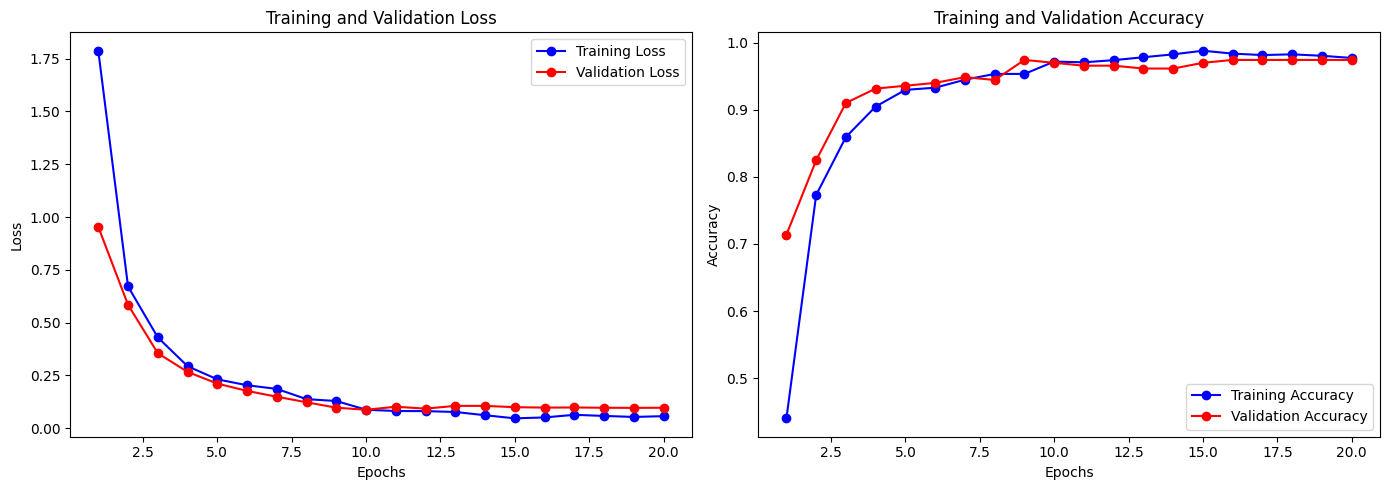

In [30]:
# Extract training and validation loss for visualization
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create an array representing the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation losses
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', marker='o', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [31]:
# Prediction and evaluation on test set
from sklearn.metrics import classification_report
real_label = []
predicted_class = []
false_predictions = []

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)

        # Apply preprocessing for prediction
        img = preprocess_image(img)  # Preprocess without adding the batch dimension here
        img = np.expand_dims(img, axis=0)  # Add batch dimension

        # Make prediction
        predictions = model.predict(img)
        real_label.append(folder)
        predicted_class_index = np.argmax(predictions)
        predicted_label = le.classes_[predicted_class_index]
        predicted_class.append(predicted_label)

        # Check if prediction is incorrect
        if predicted_label != folder:
            false_predictions.append((file_path, folder, predicted_label))

# Print classification report
print(classification_report(real_label, predicted_class, target_names=le.classes_))

# Display false predictions
print("\nFalse Predictions:")
for file_path, true_label, predicted_label in false_predictions:
    print(f"Image: {file_path}, True Label: {true_label}, Predicted Label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

In [32]:
# Print classification report
print(classification_report(real_label, predicted_class, target_names=le.classes_))

                            precision    recall  f1-score   support

            BA- cellulitis       0.94      0.97      0.96        34
               BA-impetigo       0.95      1.00      0.98        20
           FU-athlete-foot       0.94      0.97      0.95        32
            FU-nail-fungus       1.00      0.97      0.98        33
               FU-ringworm       1.00      0.91      0.95        23
PA-cutaneous-larva-migrans       0.92      0.96      0.94        25
             VI-chickenpox       1.00      1.00      1.00        34
               VI-shingles       1.00      0.97      0.98        33

                  accuracy                           0.97       234
                 macro avg       0.97      0.97      0.97       234
              weighted avg       0.97      0.97      0.97       234



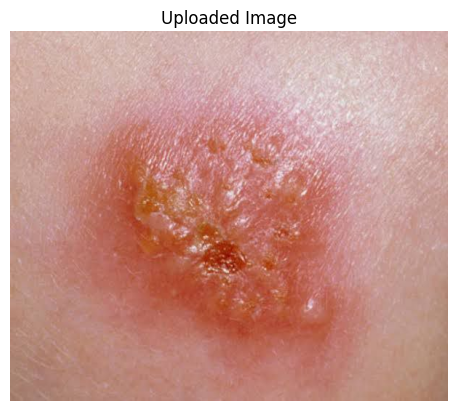

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Predicted label: BA-impetigo


In [36]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
# Function to preprocess uploaded image
def preprocess_image(img):
    # Convert BGR to RGB for consistency
    if img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize to match the input size of the model (299, 299 for ResNet)
    img = cv2.resize(img, (299, 299))
    img = img.astype('float32')
    img = preprocess_input(img)  # Use preprocess_input based on the model
    return img

# Select an image file path (replace with your image file path)
img_path = r'C:\Users\ahmed\OneDrive\Desktop\skin new last\photo.jpg'
img = cv2.imread(img_path)
img = cv2.imread(img_path)

# Check if the image was successfully loaded
if img is None:
    print(f"Error: Unable to load the image at {img_path}")
else:
    # Display the uploaded image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
    plt.axis('off')  # Hide axis
    plt.title("Uploaded Image")
    plt.show()

    # Preprocess and make prediction
    img = preprocess_image(img)  # Apply preprocessing function
    img = np.expand_dims(img, axis=0)  # Add batch dimension for prediction

    # Make prediction
    predictions = model.predict(img)
    predicted_class_index = np.argmax(predictions)
    predicted_label = le.classes_[predicted_class_index]

    print(f'Predicted label: {predicted_label}')

In [37]:
# Save the model in .h5 format
model.save('model.h5')
print("Model saved as 'model.h5'")

Model saved as 'model.h5'


In [38]:
model.save(r'C:\Users\ahmed\OneDrive\Desktop\skin new last\model.h5')
print("Model saved in 'skin new last' folder")

Model saved in 'skin new last' folder


In [40]:
model.save_weights(r'C:\Users\ahmed\OneDrive\Desktop\skin new last\model_weights_only.weights.h5')
print("Model weights saved in 'skin new last' folder")

Model weights saved in 'skin new last' folder


In [41]:
import tensorflow as tf
print(tf.__version__)

2.18.0
